In [3]:
import sys
import numpy as np
sys.path.append("../")

%load_ext autoreload
%autoreload 2
from nxedit.classes.ExpManager import ExpManager
from nxedit.draw import save_graph_html
from nxedit.GraphFingerprint.GraphFingerprint import GraphFingerprint
from nxedit.GraphFingerprint.utils import get_node_id_with_fp_key


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load json data exported by the server
- there are some converting errors (to be fixed)

In [4]:

dump_path="gc_data.json"
manager=ExpManager(dump_path)

error all nodes must be connected in a graph glassy_polymer499
error all nodes must be connected in a graph glassy_polymer423
error all nodes must be connected in a graph glassy_polymer372
error all nodes must be connected in a graph glassy_polymer371
error all nodes must be connected in a graph glassy_polymer370
error all nodes must be connected in a graph glassy_polymer369
error all nodes must be connected in a graph glassy_polymer368
error all nodes must be connected in a graph glassy_polymer231
error all nodes must be connected in a graph glassy_polymer230
error all nodes must be connected in a graph glassy_polymer229
error all nodes must be connected in a graph glassy_polymer228
error all nodes must be connected in a graph glassy_polymer227
error all nodes must be connected in a graph glassy_polymer226
error all nodes must be connected in a graph glassy_polymer225
error all nodes must be connected in a graph glassy_polymer224
error all nodes must be connected in a graph glassy_pol

In [5]:
#calculate fingerprint
g_list=[manager.exp_dict[k]["exp"].g for k in manager.exp_dict]
fp_class=GraphFingerprint(g_list)
fp_array=np.array([fp_class(g) for g in g_list])
fp_array.shape

(525, 570)

In [6]:
#search for target node
#in this case, we look for a numeric node containing ionic conductivity
[i for i  in fp_class.key_list if i.find("ionic cond")>0]

['*NUM-i-[S/cm]-o-[ionic conductivity]',
 'Measure EIS-i-[Break vacuum pack:DC voltage:equipment:ionic conductivity:machine:temperature]-o-[Disassemble cell]',
 'Measure EIS-i-[Break vacuum pack:DC voltage:equipment:ionic conductivity]-o-[Disassemble cell]',
 'Measure EIS-i-[Carry out from glove box:DC voltage:equipment:ionic conductivity:machine:temperature]-o-[Disassemble cell]',
 'Measure EIS-i-[Carry out from glove box:DC voltage:equipment:ionic conductivity]-o-[Disassemble cell]',
 'Measure EIS-i-[DC voltage:Fabricate cell:equipment:ionic conductivity]-o-[Disassemble cell]',
 'Measure EIS-i-[DC voltage:Leave:equipment:ionic conductivity]-o-[Disassemble cell]']

# Visualize one graph
- emphasize the conductiviy node
- save as "show1.html"

In [9]:

target_fp_key='*NUM-i-[S/cm]-o-[ionic conductivity]'
graph_id="171_1"
g=manager.exp_dict[graph_id]["exp"].g
mark_node_id=get_node_id_with_fp_key(g,target_fp_key)[0]
save_graph_html(g,color_dict={mark_node_id:'#dd4b39'},save_path="show1.html")

In [10]:
# view on jupyter (in development)
"""
from IPython.core.display import HTML
import panel as pn
pn.extension(comms='ipywidgets')
display(HTML('temp/fc.html'))

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

@interact(n=[1, 2, 3], color=['red', 'green', 'blue'])
def func(n, color):
    x = np.linspace(-100, 100)
    plt.plot(x, x**n, color=color)
    #display(HTML('temp/fc.html'))    

"""

"\nfrom IPython.core.display import HTML\nimport panel as pn\npn.extension(comms='ipywidgets')\ndisplay(HTML('temp/fc.html'))\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom ipywidgets import interact\n\n@interact(n=[1, 2, 3], color=['red', 'green', 'blue'])\ndef func(n, color):\n    x = np.linspace(-100, 100)\n    plt.plot(x, x**n, color=color)\n    #display(HTML('temp/fc.html'))    \n\n"

# machine learning
- Predict conductivity from graph data
- Visualize important nodes

In [11]:
import pandas as pd
df=pd.DataFrame(fp_array)
df.columns=list(fp_class.key_list)
df=df[df[target_fp_key]==df[target_fp_key]]
df=df.dropna(axis=1,how="all")
df=df.astype(float)

df[target_fp_key]=np.log10(df[target_fp_key])
X=df.drop(target_fp_key,axis=1)
y=df[target_fp_key]


In [12]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

tr_X,te_X,tr_y,te_y=train_test_split(X,y,test_size=0.3)
imp = SimpleImputer() 


imp.fit_transform(X)
tr_X=imp.transform(tr_X)
te_X=imp.transform(te_X)

Text(0, 0.5, 'Predicted')

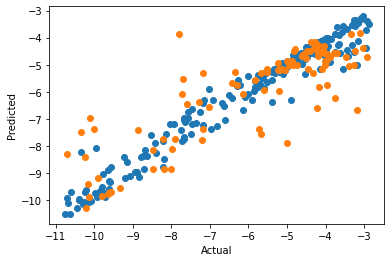

In [14]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
model=RandomForestRegressor()
model.fit(tr_X,tr_y)

p_tr_y=model.predict(tr_X)
p_te_y=model.predict(te_X)

plt.scatter(tr_y,p_tr_y)
plt.scatter(te_y,p_te_y)
plt.xlabel("Actual")
plt.ylabel("Predicted")

# analyze
- Use SHAP values

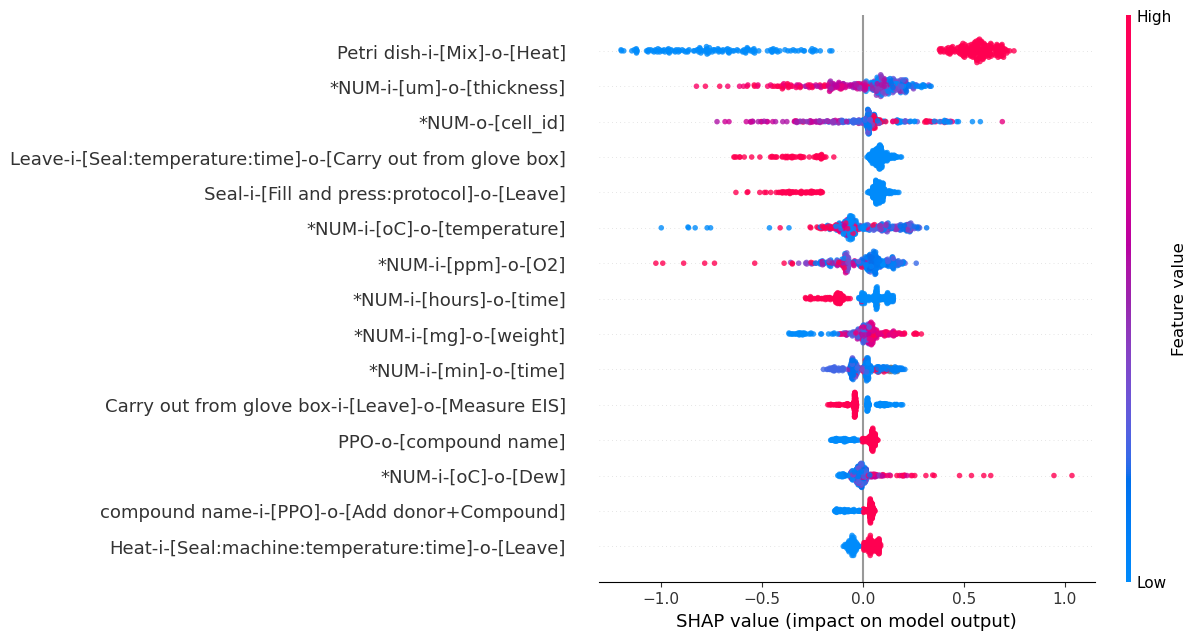

In [15]:
import shap

#simply show important features

explainer = shap.TreeExplainer(model, data=X)
col_names=list(X.columns)

plt.figure(dpi=100)
X_shap_values = explainer.shap_values(X, check_additivity=False)
shap.summary_plot(
    shap_values=X_shap_values,
    features=X,
    feature_names=col_names,
    max_display=15,
    alpha=0.8
)

# Visualize important nodes for a specific graph
- Save as "show2.html"

In [16]:
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import MinMaxScaler

def color_code(x,cmap=plt.get_cmap("jet")):
    return rgb2hex(cmap(x))

exp_id_to_pandas_id={k:v for k,v in zip(manager.exp_dict,range(len(manager.exp_dict)))}
pandas_id_to_shap_id={k:v for k,v in zip(df.index,range(df.shape[0]))}


In [17]:
graph_id="171_1"
g=manager.exp_dict[graph_id]["exp"].g

target_shap_id=pandas_id_to_shap_id[exp_id_to_pandas_id[graph_id]]
shap_val=X_shap_values[target_shap_id]
shap_dict={k:v for k,v in zip(X.columns,shap_val)}
scaled_vals=MinMaxScaler().fit_transform(np.array(list(shap_dict.values())).reshape(-1,1))
shap_color_dict={k:color_code(v[0]) for k,v in zip(shap_dict,scaled_vals)}

node_color_dict={}
for target_fp_key in shap_color_dict:
    mark_node_ids=get_node_id_with_fp_key(g,target_fp_key)
    for nid in mark_node_ids:
        node_color_dict[nid]=shap_color_dict[target_fp_key]
save_graph_html(g,color_dict=node_color_dict,save_path="show2.html")